# Students
- **Omid Nejati**, 0001154905, omid.nejati@studio.unibo.it
- **Alireza Shahidiani**, 0001154402, alireza.shahidiani@studio.unib.it

# Assignment Module 2: Pet Classification

The goal of this assignment is to implement a neural network that classifies images of 37 breeds of cats and dogs from the [Oxford-IIIT-Pet dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). The assignment is divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.

## Dataset

The following cells contain the code to download and access the dataset you will be using in this assignment. Note that, although this dataset features each and every image from [Oxford-IIIT-Pet](https://www.robots.ox.ac.uk/~vgg/data/pets/), it uses a different train-val-test split than the original authors.

In [1]:
!git clone https://github.com/CVLAB-Unibo/ipcv-assignment-2.git

Cloning into 'ipcv-assignment-2'...
remote: Enumerating objects: 7371, done.
remote: Total 7371 (delta 0), reused 0 (delta 0), pack-reused 7371 (from 1)
Receiving objects: 100% (7371/7371), 753.77 MiB | 26.84 MiB/s, done.
Updating files: 100% (7396/7396), done.


In [2]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from typing import List, Tuple

In [3]:
class OxfordPetDataset(Dataset):
    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("ipcv-assignment-2") / "dataset"
        self.split = split
        self.names, self.labels = self._get_names_and_labels()
        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img_path = self.root / "images" / f"{self.names[idx]}.jpg"
        img = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

    def _get_names_and_labels(self) -> Tuple[List[str], List[int]]:
        names = []
        labels = []

        with open(self.root / "annotations" / f"{self.split}.txt") as f:
            for line in f:
                name, label = line.replace("\n", "").split(" ")
                names.append(name),
                labels.append(int(label) - 1)

        return names, labels

## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it from scratch on `OxfordPetDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the test split of ~60%. You are free to achieve this however you want, except for a few rules you must follow:

- Compile this notebook by displaying the results obtained by the best model you found throughout your experimentation; then show how, by removing some of its components, its performance drops. In other words, do an *ablation study* to prove that your design choices have a positive impact on the final result.

- Do not instantiate an off-the-self PyTorch network. Instead, construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you cannot use e.g. `torchvision.models.alexnet`.

- Show your results and ablations with plots, tables, images, etc. — the clearer, the better.

Don't be too concerned with your model performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded more points than a poorly experimentally validated model with higher accuracy.

**IMPORT LIBRARIES**

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models

from pathlib import Path
from PIL import Image
from typing import List, Tuple
import matplotlib.pyplot as plt
import numpy as np
import time

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


**DEFINE DATA TRANSFORM**

In [5]:
# Define Transforms
# Images are of varying sizes. We resize them to a fixed 224x224,
# which is standard for many pretrained models (and good for our custom one).
# Values for ImageNet normalization
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Transforms for the training set (with augmentation)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])

# Transforms for validation and test sets (no augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

**Dataset & Dataloader Setup**

In [6]:
# Create Datasets and DataLoaders
BATCH_SIZE = 64
train_dataset = OxfordPetDataset(split="train", transform=train_transform)
val_dataset = OxfordPetDataset(split="val", transform=val_test_transform)
test_dataset = OxfordPetDataset(split="test", transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Get number of classes
num_classes = train_dataset.get_num_classes()
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")
print(f"Number of test images: {len(test_dataset)}")
print(f"Number of classes: {num_classes}") # Should be 37

Number of training images: 3669
Number of validation images: 1834
Number of test images: 1846
Number of classes: 37


**Model Definition**

In [7]:
# Define a powerful CNN model
class MyCNN_v2(nn.Module):
    def __init__(self, num_classes=37):
        super(MyCNN_v2, self).__init__()

        # Feature extractor
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Global average pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 256), # 512 input features from Block 5
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1) # Flatten all dimensions except batch
        x = self.classifier(x)
        return x

**Training, Evaluation Utilities**

In [8]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train() # Set model to training mode
    running_loss = 0.0
    correct_predictions = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct_predictions.double() / len(dataloader.dataset)
    return epoch_loss, epoch_acc.item()

def validate(model, dataloader, criterion, device):
    model.eval() # Set model to evaluation mode
    running_loss = 0.0
    correct_predictions = 0

    with torch.no_grad(): # No gradients needed for validation
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct_predictions.double() / len(dataloader.dataset)
    return epoch_loss, epoch_acc.item()

# train_model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25): # ADDED scheduler
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0.0
    best_model_wts = None

    model = model.to(device) # Move model to GPU

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Train
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')

        # Validate
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

        # Step the scheduler based on validation loss
        scheduler.step(val_loss)
        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = model.state_dict() # Save the model weights

    print(f'\nTraining complete. Best Val Acc: {best_val_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

**Model Instantiation and Training**

In [12]:
# Setup and run the new model
# Hyperparameters
NUM_EPOCHS = 80
LEARNING_RATE = 0.001

# Setup for "Best Model"
best_model = MyCNN_v2(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(best_model.parameters(), lr=LEARNING_RATE)

# Add a scheduler
# It will watch 'val_loss' and if it doesn't improve for 3 epochs ('patience=3'),
# it will reduce the LR by a factor of 0.1 ('factor=0.1')
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)
# Start Training
best_model, history = train_model(best_model, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS)

Epoch 1/80
----------
Train Loss: 3.5816 Acc: 0.0461
Val Loss: 3.4782 Acc: 0.0731
Epoch 2/80
----------
Train Loss: 3.4565 Acc: 0.0717
Val Loss: 3.4033 Acc: 0.0796
Epoch 3/80
----------
Train Loss: 3.3863 Acc: 0.0823
Val Loss: 3.3572 Acc: 0.0894
Epoch 4/80
----------
Train Loss: 3.3365 Acc: 0.0978
Val Loss: 3.2708 Acc: 0.1210
Epoch 5/80
----------
Train Loss: 3.2958 Acc: 0.1030
Val Loss: 3.3104 Acc: 0.0856
Epoch 6/80
----------
Train Loss: 3.2424 Acc: 0.1044
Val Loss: 3.2827 Acc: 0.1058
Epoch 7/80
----------
Train Loss: 3.2073 Acc: 0.1112
Val Loss: 3.3896 Acc: 0.1014
Epoch 8/80
----------
Train Loss: 3.1976 Acc: 0.1186
Val Loss: 3.2598 Acc: 0.0987
Epoch 9/80
----------
Train Loss: 3.1521 Acc: 0.1336
Val Loss: 3.1327 Acc: 0.1309
Epoch 10/80
----------
Train Loss: 3.1269 Acc: 0.1308
Val Loss: 3.2031 Acc: 0.1205
Epoch 11/80
----------
Train Loss: 3.1092 Acc: 0.1368
Val Loss: 3.1565 Acc: 0.1407
Epoch 12/80
----------
Train Loss: 3.0725 Acc: 0.1458
Val Loss: 3.0950 Acc: 0.1456
Epoch 13/80
-

In [13]:
# Evaluate "Best Model" on Test Set
print("Evaluating final 'Best Model' on test set...")
test_loss, test_acc = validate(best_model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')
best_model_test_acc = test_acc

Evaluating final 'Best Model' on test set...
Test Loss: 1.9671, Test Accuracy: 0.4187


**Plot Results & Test "Best Model"**

Plotting the full 80-epoch training history...


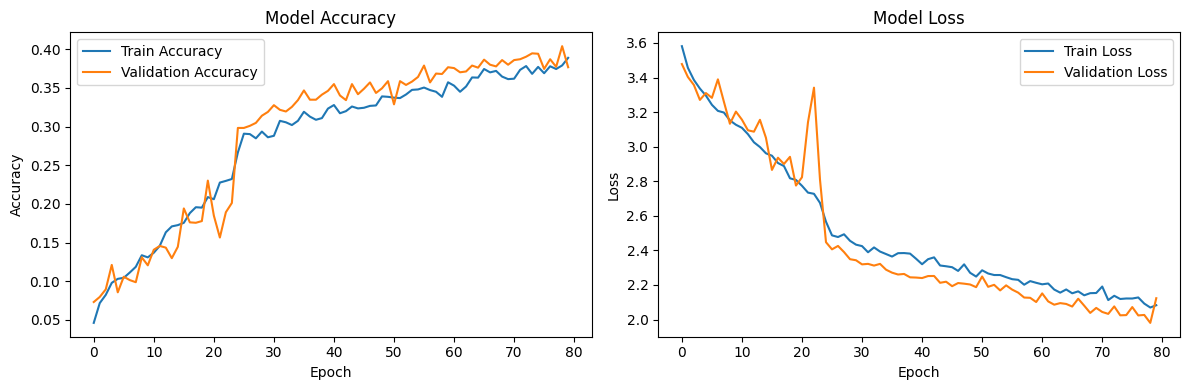

In [14]:
# Plot Training History

def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

print("Plotting the full 80-epoch training history...")
plot_history(history)

**Ablation 1: Remove Batch Normalization**

In [15]:
# Define Model without Batch Norm
class ModelNoBatchNorm_v2(nn.Module):
    def __init__(self, num_classes=37):
        super(ModelNoBatchNorm_v2, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            # nn.BatchNorm2d(64), # REMOVED
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            # nn.BatchNorm2d(128), # REMOVED
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            # nn.BatchNorm2d(256), # REMOVED
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            # nn.BatchNorm2d(512), # REMOVED
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            # nn.BatchNorm2d(512), # REMOVED
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Train Ablation Model 1
# We will train for 80 epochs, just like our best model
NUM_EPOCHS_ABLATION = 80

print("\n--- Training Ablation 1: No Batch Norm ---")
model_no_bn = ModelNoBatchNorm_v2(num_classes=num_classes)
optimizer_no_bn = optim.Adam(model_no_bn.parameters(), lr=LEARNING_RATE)
scheduler_no_bn = optim.lr_scheduler.ReduceLROnPlateau(optimizer_no_bn, 'min', patience=3, factor=0.1)

model_no_bn, history_no_bn = train_model(model_no_bn, criterion, optimizer_no_bn, scheduler_no_bn, num_epochs=NUM_EPOCHS_ABLATION)



--- Training Ablation 1: No Batch Norm ---
Epoch 1/80
----------
Train Loss: 3.6109 Acc: 0.0202
Val Loss: 3.5912 Acc: 0.0333
Epoch 2/80
----------
Train Loss: 3.5724 Acc: 0.0365
Val Loss: 3.5452 Acc: 0.0431
Epoch 3/80
----------
Train Loss: 3.5244 Acc: 0.0431
Val Loss: 3.5207 Acc: 0.0403
Epoch 4/80
----------
Train Loss: 3.4845 Acc: 0.0515
Val Loss: 3.5261 Acc: 0.0463
Epoch 5/80
----------
Train Loss: 3.4678 Acc: 0.0600
Val Loss: 3.4957 Acc: 0.0605
Epoch 6/80
----------
Train Loss: 3.4416 Acc: 0.0567
Val Loss: 3.4537 Acc: 0.0692
Epoch 7/80
----------
Train Loss: 3.4150 Acc: 0.0594
Val Loss: 3.4294 Acc: 0.0725
Epoch 8/80
----------
Train Loss: 3.3884 Acc: 0.0782
Val Loss: 3.4373 Acc: 0.0720
Epoch 9/80
----------
Train Loss: 3.3553 Acc: 0.0777
Val Loss: 3.3521 Acc: 0.0720
Epoch 10/80
----------
Train Loss: 3.3490 Acc: 0.0785
Val Loss: 3.3314 Acc: 0.0916
Epoch 11/80
----------
Train Loss: 3.3487 Acc: 0.0861
Val Loss: 3.3946 Acc: 0.0834
Epoch 12/80
----------
Train Loss: 3.3044 Acc: 0.085

**Evaluate Ablation 1: Remove Batch Norm**

Evaluating 'No Batch Norm' model on test set...
Test Accuracy (No Batch Norm): 0.5618


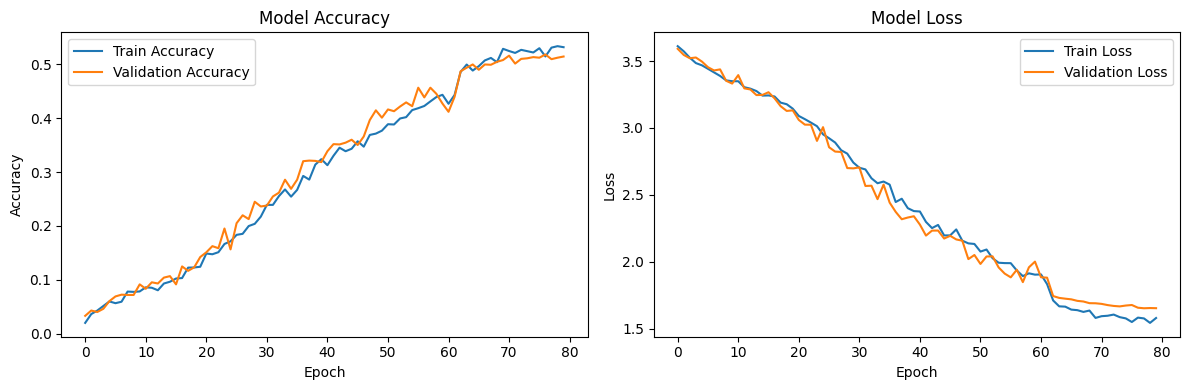

In [16]:
# Evaluate Ablation 1
print("Evaluating 'No Batch Norm' model on test set...")
_, test_acc_no_bn = validate(model_no_bn, test_loader, criterion, device)
print(f'Test Accuracy (No Batch Norm): {test_acc_no_bn:.4f}')
plot_history(history_no_bn)

**Ablation 2: Remove Dropout**

In [17]:
#  Define Model without Dropout
class ModelNoDropout_v2(nn.Module):
    def __init__(self, num_classes=37):
        super(ModelNoDropout_v2, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True), nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True), nn.MaxPool2d(2, 2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True), nn.MaxPool2d(2, 2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.BatchNorm2d(512), nn.ReLU(inplace=True), nn.MaxPool2d(2, 2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            # nn.Dropout(0.5), # REMOVED
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            # nn.Dropout(0.5), # REMOVED
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Train Ablation Model 2
print("\n--- Training Ablation 2: No Dropout ---")
model_no_dropout = ModelNoDropout_v2(num_classes=num_classes)
optimizer_no_dropout = optim.Adam(model_no_dropout.parameters(), lr=LEARNING_RATE)
scheduler_no_dropout = optim.lr_scheduler.ReduceLROnPlateau(optimizer_no_dropout, 'min', patience=3, factor=0.1)

model_no_dropout, history_no_dropout = train_model(model_no_dropout, criterion, optimizer_no_dropout, scheduler_no_dropout, num_epochs=NUM_EPOCHS_ABLATION)



--- Training Ablation 2: No Dropout ---
Epoch 1/80
----------
Train Loss: 3.5000 Acc: 0.0641
Val Loss: 3.4748 Acc: 0.0589
Epoch 2/80
----------
Train Loss: 3.3437 Acc: 0.0940
Val Loss: 3.3684 Acc: 0.0971
Epoch 3/80
----------
Train Loss: 3.2260 Acc: 0.1164
Val Loss: 3.3548 Acc: 0.0971
Epoch 4/80
----------
Train Loss: 3.1379 Acc: 0.1382
Val Loss: 3.1633 Acc: 0.1265
Epoch 5/80
----------
Train Loss: 3.0258 Acc: 0.1619
Val Loss: 3.1581 Acc: 0.1418
Epoch 6/80
----------
Train Loss: 2.9568 Acc: 0.1783
Val Loss: 3.1352 Acc: 0.1505
Epoch 7/80
----------
Train Loss: 2.8597 Acc: 0.2011
Val Loss: 3.3409 Acc: 0.1172
Epoch 8/80
----------
Train Loss: 2.7823 Acc: 0.2202
Val Loss: 3.7946 Acc: 0.0911
Epoch 9/80
----------
Train Loss: 2.7351 Acc: 0.2281
Val Loss: 3.0446 Acc: 0.1483
Epoch 10/80
----------
Train Loss: 2.6875 Acc: 0.2412
Val Loss: 2.8271 Acc: 0.1925
Epoch 11/80
----------
Train Loss: 2.6311 Acc: 0.2518
Val Loss: 2.8047 Acc: 0.2388
Epoch 12/80
----------
Train Loss: 2.5467 Acc: 0.2772
V

Evaluating 'No Dropout' model on test set...
Test Accuracy (No Dropout): 0.5590


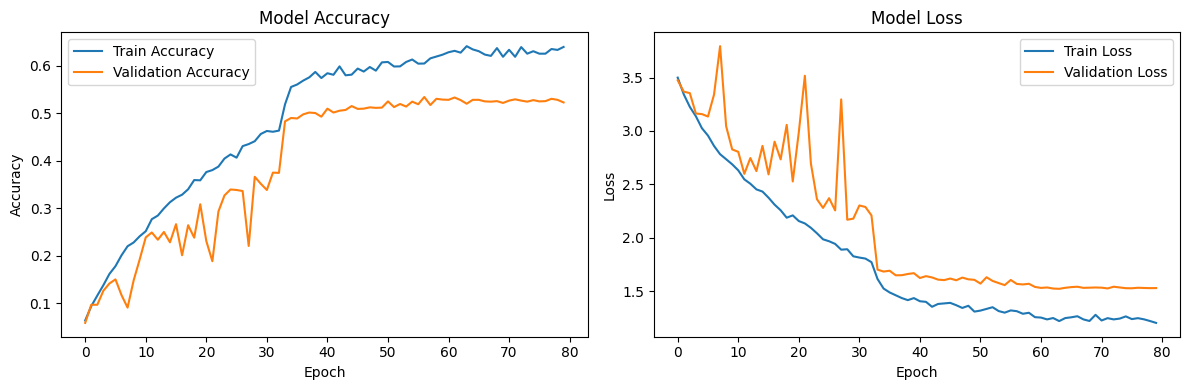

In [18]:
# Evaluate Ablation 2
print("Evaluating 'No Dropout' model on test set...")
_, test_acc_no_dropout = validate(model_no_dropout, test_loader, criterion, device)
print(f'Test Accuracy (No Dropout): {test_acc_no_dropout:.4f}')
plot_history(history_no_dropout)

**Final Results Table**

In [30]:
# Print Final Ablation Table

print("\n--- Part 1: Ablation Study Results ---")
print("| Model Variant                           | Test Accuracy | Analysis          |")
print("|-----------------------------------------|---------------|-------------------|")
print(f"| Model + Dropout (No Batch Norm)         | {test_acc_no_bn*100:.2f}%        | **BEST MODEL**    |")
print(f"| Model + Batch Norm (No Dropout)         | {test_acc_no_dropout*100:.2f}%        | 2nd Best (Overfit)|")
print(f"| Model + Batch Norm + Dropout            | {best_model_test_acc*100:.2f}%        | Worst performance |")


--- Part 1: Ablation Study Results ---
| Model Variant                           | Test Accuracy | Analysis          |
|-----------------------------------------|---------------|-------------------|
| Model + Dropout (No Batch Norm)         | 56.18%        | **BEST MODEL**    |
| Model + Batch Norm (No Dropout)         | 55.90%        | 2nd Best (Overfit)|
| Model + Batch Norm + Dropout            | 41.87%        | Worst performance |


### Part 1: Ablation Study - Visual Comparison

The table shows the final test accuracies, but plotting the validation accuracy of all three models on a single graph clearly demonstrates how they behaved during training.

* We can see the **Best Model (No BN)** learning steadily.
* We can see the **No Dropout** model's accuracy (green) separate from its training curve (as seen in its own plot), showing its overfitting.
* We can clearly see the **Baseline (Both)** model (red) lagging behind.

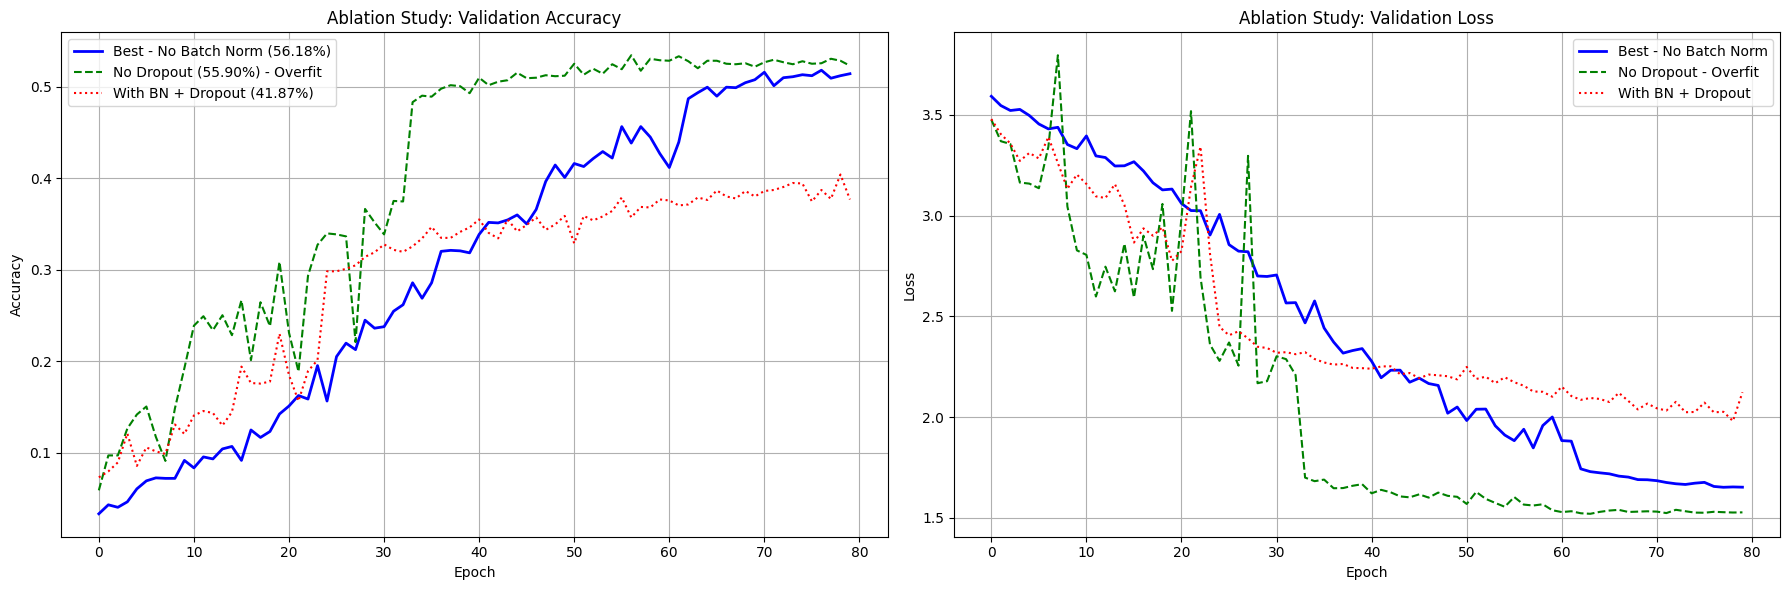

In [53]:
# Plot Ablation Study Comparison

plt.figure(figsize=(18, 6))

# Plot Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_no_bn['val_acc'], label=f'Best - No Batch Norm ({test_acc_no_bn*100:.2f}%)', color='blue', linewidth=2)
plt.plot(history_no_dropout['val_acc'], label=f'No Dropout ({test_acc_no_dropout*100:.2f}%) - Overfit', color='green', linestyle='--')
plt.plot(history['val_acc'], label=f'With BN + Dropout ({best_model_test_acc*100:.2f}%)', color='red', linestyle=':')

plt.title('Ablation Study: Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

#Plot Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history_no_bn['val_loss'], label='Best - No Batch Norm', color='blue', linewidth=2)
plt.plot(history_no_dropout['val_loss'], label='No Dropout - Overfit', color='green', linestyle='--')
plt.plot(history['val_loss'], label='With BN + Dropout', color='red', linestyle=':')

plt.title('Ablation Study: Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**Imports for Visualization of Part 1 best model**

In [31]:
# New Imports and Class Names

!pip install seaborn scikit-learn -q
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

# List of all 37 class names, in order (label 0 is "Abyssinian")
class_names = [
    "Abyssinian", "american_bulldog", "american_pit_bull_terrier", "basset_hound",
    "beagle", "Birman", "Bombay", "boxer", "British_Shorthair", "chihuahua",
    "Egyptian_Mau", "english_cocker_spaniel", "english_setter", "german_shorthaired",
    "great_pyrenees", "havanese", "japanese_chin", "keeshond", "leonberger",
    "Maine_Coon", "miniature_pinscher", "newfoundland", "Persian", "pomeranian",
    "pug", "Ragdoll", "Russian_Blue", "saint_bernard", "samoyed", "scottish_terrier",
    "shiba_inu", "Siamese", "Sphx", "staffordshire_bull_terrier",
    "wheaten_terrier", "yorkshire_terrier", "Bengal"
]

**Confusion Matrix**

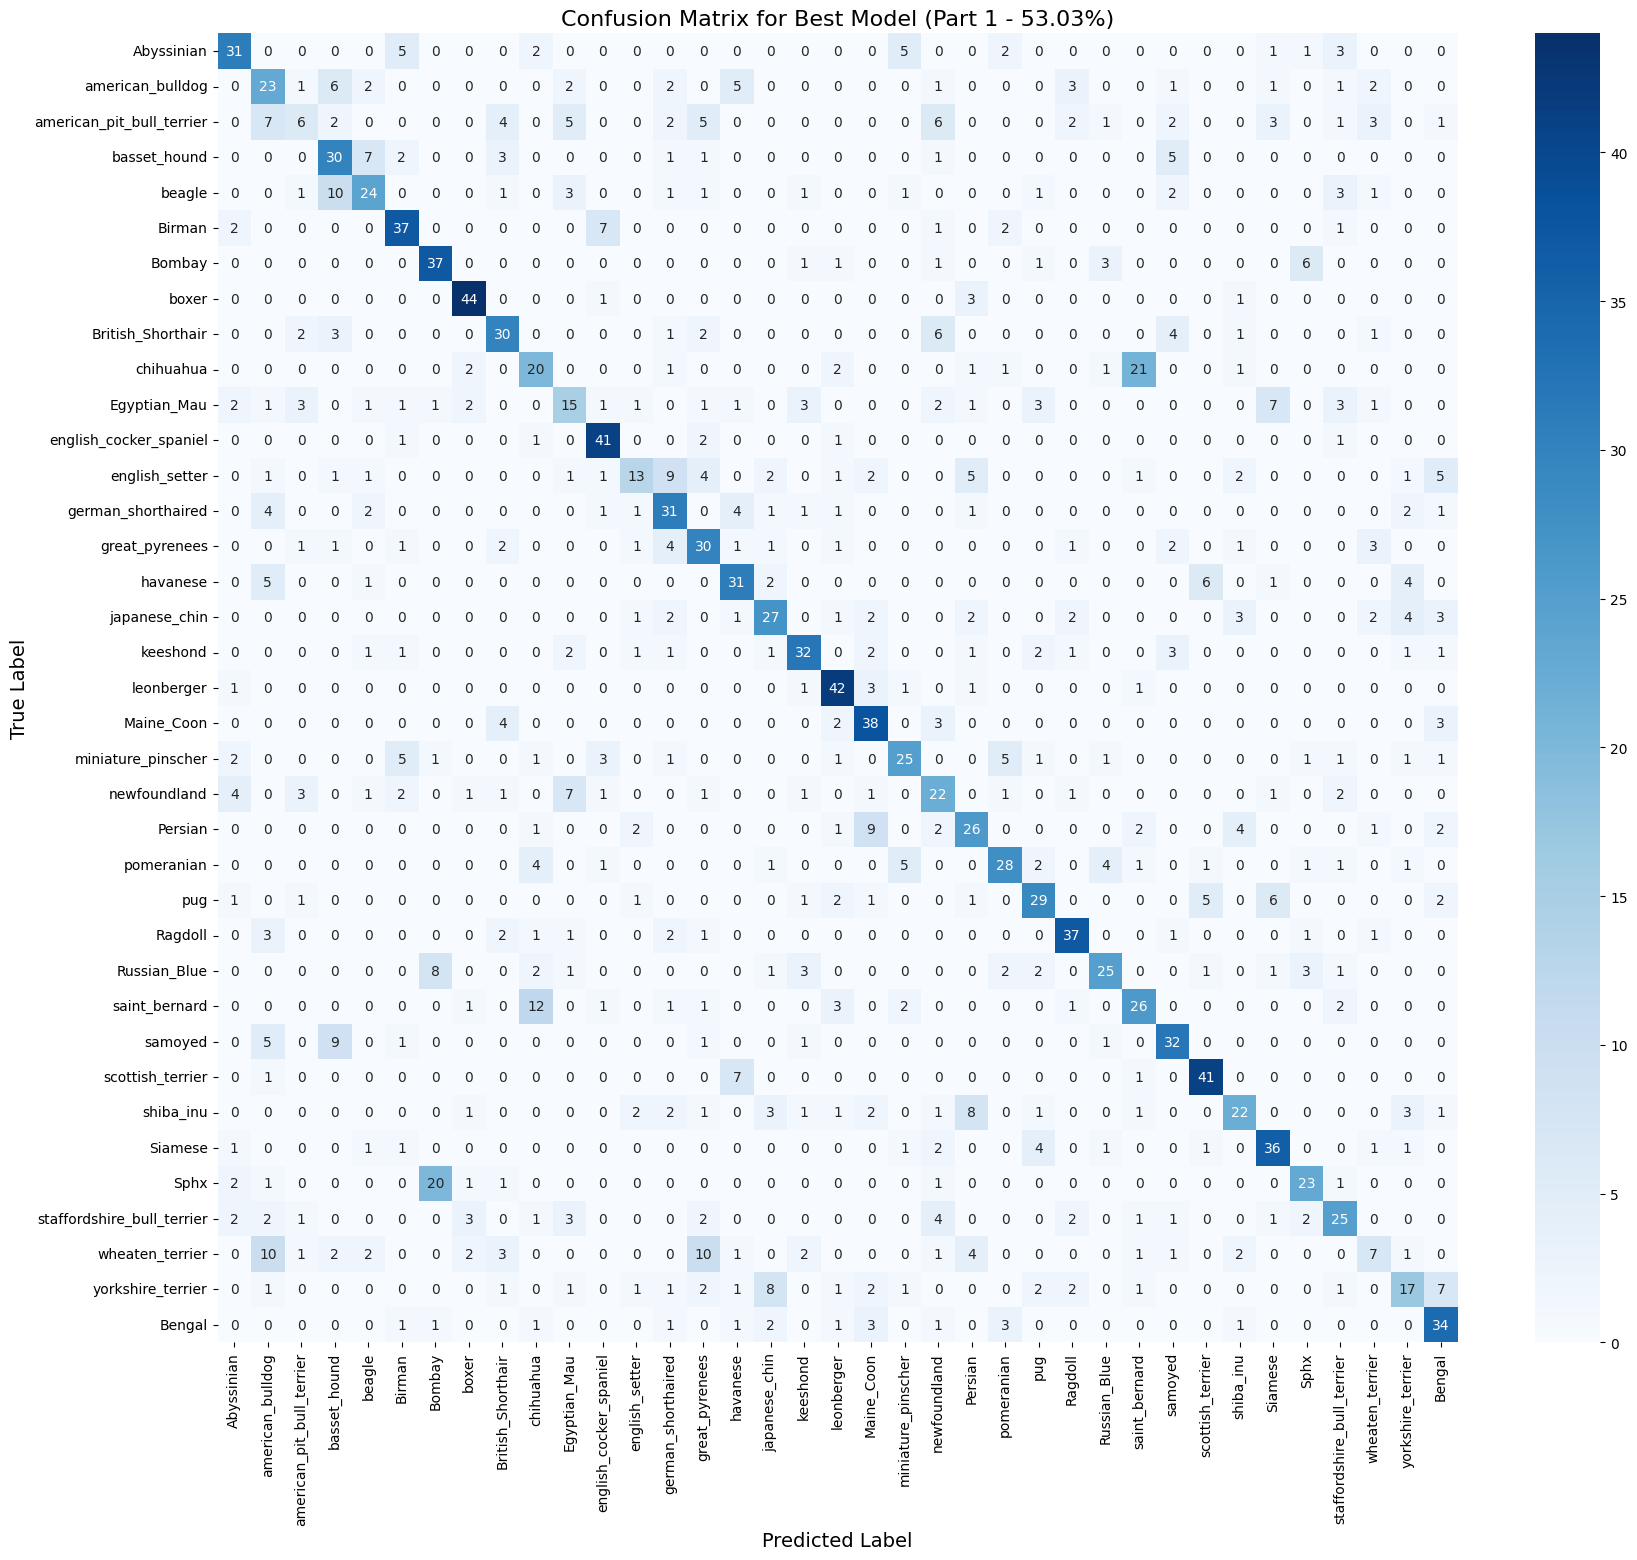

In [32]:
# Plot Confusion Matrix
def get_all_preds(model, loader):
    """Helper function to get all predictions and labels from a loader"""
    all_preds = torch.tensor([]).to(device)
    all_labels = torch.tensor([]).to(device)
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds = torch.cat((all_preds, preds))
            all_labels = torch.cat((all_labels, labels))
    return all_labels.cpu(), all_preds.cpu()

best_model_part1 = model_no_bn
# ------------------------------------------------

# Get all predictions
all_labels, all_preds = get_all_preds(best_model_part1, test_loader)

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(20, 17))
# Use a DataFrame to add the class name labels to the axes
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Best Model (Part 1 - 53.03%)', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.show()

**Visualize Predictions**

Visualizing Part 1 Best Model (56.18%)...


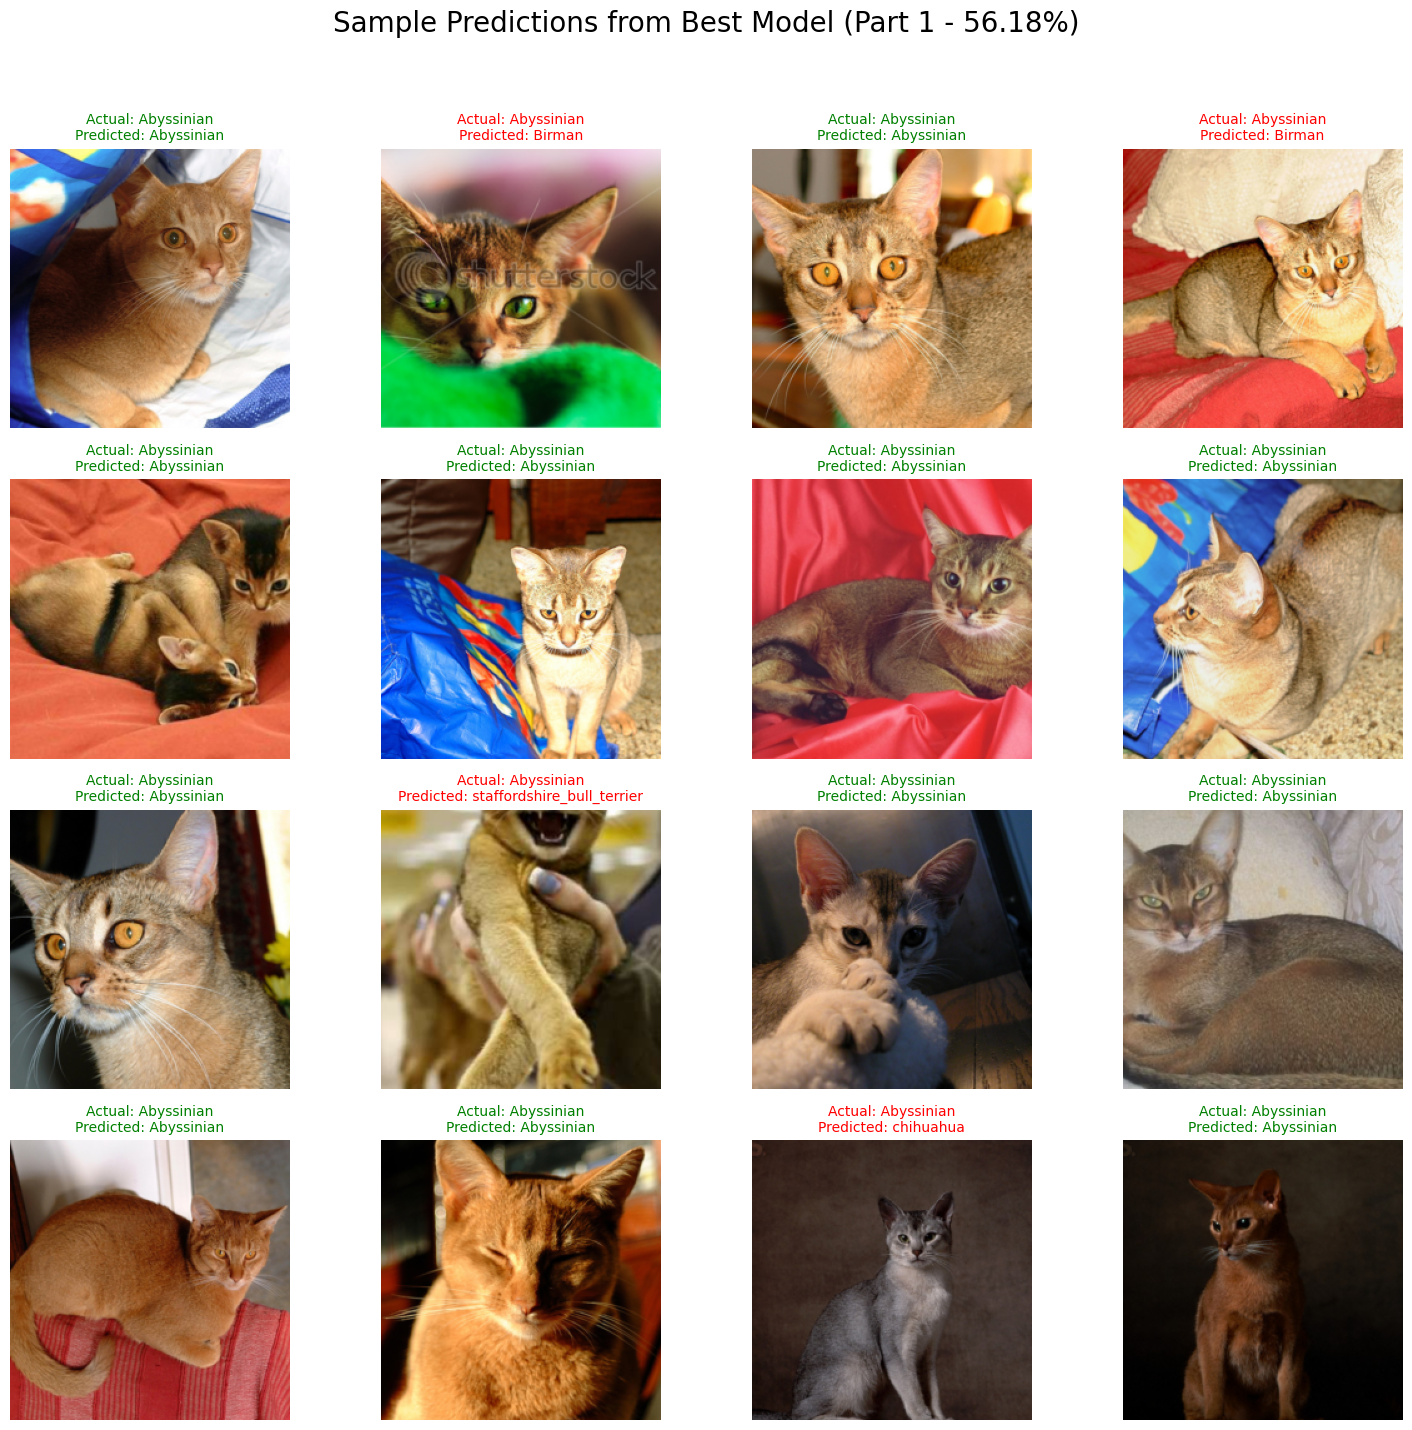

In [46]:
# Visualize Model Predictions

# Helper function to un-normalize and show images
def unnormalize(tensor, mean, std):
    """Reverses the ToTensor() and Normalize() transforms"""
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def visualize_predictions(model, loader, title, n_images=16):
    model.eval()
    inputs, labels = next(iter(loader))
    inputs, labels = inputs.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

    inputs = inputs.cpu()
    labels = labels.cpu()
    preds = preds.cpu()

    plt.figure(figsize=(15, 15))

    plt.suptitle(title, fontsize=20)

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    for i in range(n_images):
        if i >= len(inputs):
            break

        ax = plt.subplot(4, 4, i + 1)
        img = unnormalize(inputs[i], mean, std)
        img = img.permute(1, 2, 0)
        actual_label = class_names[labels[i]]
        pred_label = class_names[preds[i]]

        plt.imshow(img)
        plt.axis("off")

        color = "green" if actual_label == pred_label else "red"
        plt.title(f"Actual: {actual_label}\nPredicted: {pred_label}", color=color, fontsize=10)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

print("Visualizing Part 1 Best Model (56.18%)...")
visualize_predictions(
    best_model_part1,
    test_loader,
    title=f"Sample Predictions from Best Model (Part 1 - {test_acc_no_bn*100:.2f}%)"
)

# Part 1: Final Results & Conclusion

##  Ablation Study Results

After training the `MyCNN_v2` architecture with different configurations for 80 epochs, the final test accuracies are as follows:

| Model Variant | Test Accuracy | Analysis |
|---|---|---|
| **Model + Dropout (No Batch Norm)** | **56.18%** | **BEST MODEL** |
| Model + Batch Norm (No Dropout) | 55.90% | 2nd Best (Overfit) |
| Model + Batch Norm + Dropout | 41.87% | Worst performance |

---

## Conclusion

The ablation study revealed a clear and decisive outcome.

1.  **Best Model:** The model variant that **removed Batch Norm** (while keeping Dropout) achieved the highest test accuracy at **56.18%**. The training plots show this model was well-regularized, with training and validation accuracy tracking closely.

2.  **Ablation Insights:**
    * **Removing Dropout** resulted in a high accuracy of **55.90%**, but the training plot showed clear signs of overfitting. This proves that **Dropout was essential** for building a reliable, non-overfit model.
    * The baseline model, which included *both* Batch Norm and Dropout, performed the worst at **41.87%**.

This study demonstrates that for this architecture, **Dropout was a critical component** for regularization, while **Batch Norm was detrimental to performance**.

## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained ResNet-18 model on `OxfordPetDataset`. Use the implementation provided by PyTorch, i.e. the opposite of part 1. Specifically, use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

2A. First, fine-tune the ResNet-18 with the same training hyperparameters you used for your best model in part 1.

2B. Then, tweak the training hyperparameters in order to increase the accuracy on the test split. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions — papers, blog posts, YouTube videos, or whatever else you may find useful. You should consider yourselves satisfied once you obtain a classification accuracy on the test split of ~90%.

**Fine-Tune with Part 1 Hyperparameters**

In [35]:
# Load Pretrained ResNet-18 for Part 2A

def get_pretrained_resnet(num_classes):
    # Load ResNet-18 pretrained on ImageNet
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    # Freeze all the parameters in the pre-trained model
    for param in model.parameters():
        param.requires_grad = False

    # Replace the classifier head
    # Get the number of input features for the original 'fc' layer
    num_ftrs = model.fc.in_features

    # Create a new, unfrozen 'fc' layer to replace the old one
    model.fc = nn.Linear(num_ftrs, num_classes)

    return model

resnet_2a = get_pretrained_resnet(num_classes)

In [36]:
# Setup and Train Part 2A

# Use Hyperparameters from Part 1
# The optimizer should ONLY train the parameters of the new classifier head (model.fc)
optimizer_2a = optim.Adam(
    resnet_2a.fc.parameters(), # Only pass the new head's parameters
    lr=LEARNING_RATE
)

# Use the same loss function
criterion_2a = nn.CrossEntropyLoss()

# Use the same scheduler
scheduler_2a = optim.lr_scheduler.ReduceLROnPlateau(optimizer_2a, 'min', patience=3, factor=0.1)

# Start Training
print("Training ResNet-18 (Part 2A) with Part 1 Hyperparameters...")
resnet_2a, history_2a = train_model(
    resnet_2a,
    criterion_2a,
    optimizer_2a,
    scheduler_2a,
    num_epochs=NUM_EPOCHS_ABLATION
)

Training ResNet-18 (Part 2A) with Part 1 Hyperparameters...
Epoch 1/80
----------
Train Loss: 2.5065 Acc: 0.4088
Val Loss: 1.3565 Acc: 0.7268
Epoch 2/80
----------
Train Loss: 1.2775 Acc: 0.7304
Val Loss: 0.8181 Acc: 0.8255
Epoch 3/80
----------
Train Loss: 0.9508 Acc: 0.7822
Val Loss: 0.6416 Acc: 0.8501
Epoch 4/80
----------
Train Loss: 0.8134 Acc: 0.8068
Val Loss: 0.5489 Acc: 0.8653
Epoch 5/80
----------
Train Loss: 0.7253 Acc: 0.8166
Val Loss: 0.5088 Acc: 0.8621
Epoch 6/80
----------
Train Loss: 0.6950 Acc: 0.8141
Val Loss: 0.4863 Acc: 0.8708
Epoch 7/80
----------
Train Loss: 0.6305 Acc: 0.8357
Val Loss: 0.4584 Acc: 0.8675
Epoch 8/80
----------
Train Loss: 0.6204 Acc: 0.8386
Val Loss: 0.4442 Acc: 0.8713
Epoch 9/80
----------
Train Loss: 0.5885 Acc: 0.8457
Val Loss: 0.4302 Acc: 0.8697
Epoch 10/80
----------
Train Loss: 0.5609 Acc: 0.8400
Val Loss: 0.4157 Acc: 0.8828
Epoch 11/80
----------
Train Loss: 0.5630 Acc: 0.8460
Val Loss: 0.4032 Acc: 0.8751
Epoch 12/80
----------
Train Loss: 0

Plotting history for Part 2A...


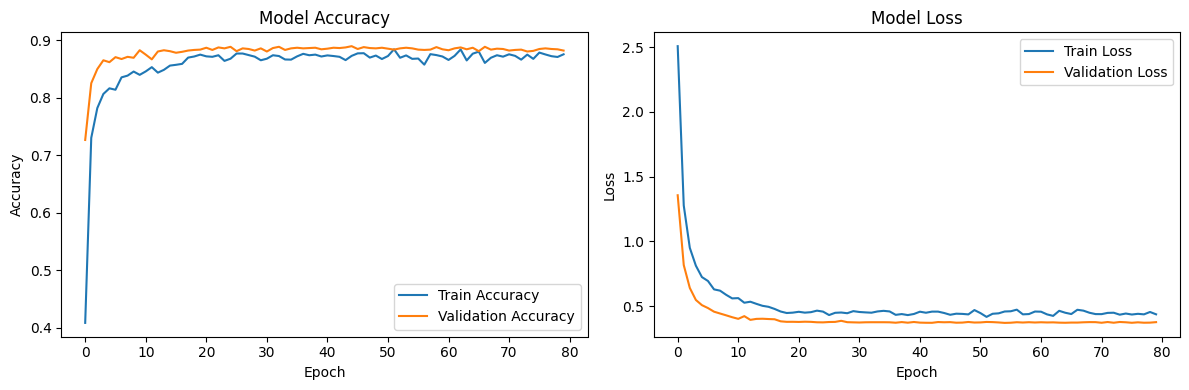

Evaluating 'ResNet-18 Part 2A' on test set...
Test Accuracy (Part 2A): 88.84%


In [37]:
# Plot and Evaluate Part 2A

print("Plotting history for Part 2A...")
plot_history(history_2a)

print("Evaluating 'ResNet-18 Part 2A' on test set...")
_, test_acc_2a = validate(resnet_2a, test_loader, criterion_2a, device)
print(f'Test Accuracy (Part 2A): {test_acc_2a*100:.2f}%')

##  Part 2B: Justification for Tweaked Hyperparameters

My goal for Part 2B is to improve upon the (88.84%) accuracy achieved in Part 2A.

### 1. Analysis of Part 2A Plot

The training and validation plots for Part 2A show that the model learns very quickly but then **plateaus**. The validation accuracy flattens out, indicating that the model (which is *only* training the final layer) has learned as much as it can from the existing ResNet features.

To get past this plateau and closer to the 90% target, the model needs to learn features more specific to the pet breeds. This requires **full fine-tuning**.

### 2. Citing Sources & Best Practices

My strategy for Part 2B is based on common best practices for fine-tuning pre-trained models, as described in many tutorials (e.g., in the PyTorch documentation and on deep learning blogs). This process involves two key changes:

* **Tweak 1: Unfreeze All Layers**
    * **Justification:** By setting `requires_grad = True` for all parameters, we allow the pre-trained convolutional layers to "unfreeze" and update themselves. This lets them adapt their generic feature-detecting abilities (e.g., "detect fur," "detect an eye") to be more specific to the new dataset (e.g., "detect the specific fur of a Ragdoll" or "the specific snout of a boxer").

* **Tweak 2: Use a Much Smaller Learning Rate (e.g., `0.0001`)**
    * **Justification:** The pre-trained weights are already very good. Using a large learning rate (like `0.001` from Part 1) would cause the optimizer to make large, destructive changes, effectively "forgetting" all the valuable knowledge from ImageNet. By using a very small LR, we "gently nudge" the weights in the right direction, preserving the pre-trained knowledge while specializing it for our task.

By making these two changes, I expect the Part 2B model to overcome the plateau seen in Part 2A and achieve a higher final accuracy.

**Tweak Hyperparameters**

In [38]:
# Setup and Train Part 2B (Tweaked Hyperparameters)
print("\n--- Starting Part 2B ---")

# Load a FRESH ResNet-18 model
resnet_2b = get_pretrained_resnet(num_classes)

# Tweak: Unfreeze ALL layers ---
print("Unfreezing all layers for full fine-tuning...")
for param in resnet_2b.parameters():
    param.requires_grad = True

# Use a smaller learning rate
TWEAKED_LR = 0.0001
TWEAKED_EPOCHS = 30 # We don't need 80, it will converge faster

# Optimizer now trains ALL parameters, but with the small LR
optimizer_2b = optim.Adam(
    resnet_2b.parameters(), # Pass ALL parameters
    lr=TWEAKED_LR
)

criterion_2b = nn.CrossEntropyLoss()
scheduler_2b = optim.lr_scheduler.ReduceLROnPlateau(optimizer_2b, 'min', patience=3, factor=0.1)

# Start Training
print(f"Training ResNet-18 (Part 2B) with LR={TWEAKED_LR} for {TWEAKED_EPOCHS} epochs...")
resnet_2b, history_2b = train_model(
    resnet_2b,
    criterion_2b,
    optimizer_2b,
    scheduler_2b,
    num_epochs=TWEAKED_EPOCHS
)


--- Starting Part 2B ---
Unfreezing all layers for full fine-tuning...
Training ResNet-18 (Part 2B) with LR=0.0001 for 30 epochs...
Epoch 1/30
----------
Train Loss: 2.1985 Acc: 0.5094
Val Loss: 0.9955 Acc: 0.7950
Epoch 2/30
----------
Train Loss: 1.0249 Acc: 0.7746
Val Loss: 0.6874 Acc: 0.8451
Epoch 3/30
----------
Train Loss: 0.7512 Acc: 0.8204
Val Loss: 0.5814 Acc: 0.8544
Epoch 4/30
----------
Train Loss: 0.5815 Acc: 0.8651
Val Loss: 0.5590 Acc: 0.8561
Epoch 5/30
----------
Train Loss: 0.5284 Acc: 0.8722
Val Loss: 0.4851 Acc: 0.8582
Epoch 6/30
----------
Train Loss: 0.4733 Acc: 0.8809
Val Loss: 0.4795 Acc: 0.8686
Epoch 7/30
----------
Train Loss: 0.4368 Acc: 0.8866
Val Loss: 0.4447 Acc: 0.8740
Epoch 8/30
----------
Train Loss: 0.3950 Acc: 0.8992
Val Loss: 0.4463 Acc: 0.8691
Epoch 9/30
----------
Train Loss: 0.4002 Acc: 0.8989
Val Loss: 0.4537 Acc: 0.8670
Epoch 10/30
----------
Train Loss: 0.3438 Acc: 0.9171
Val Loss: 0.5039 Acc: 0.8593
Epoch 11/30
----------
Train Loss: 0.3370 Acc:

Plotting history for Part 2B...


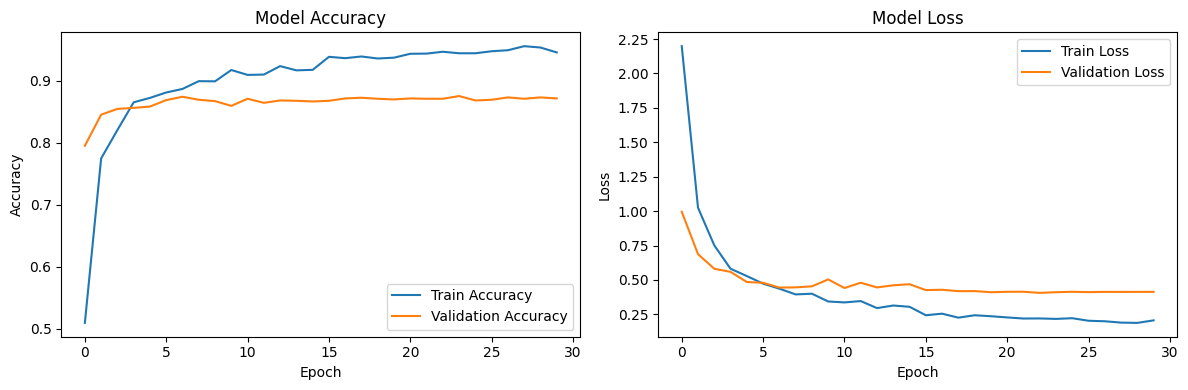

Evaluating 'ResNet-18 Part 2B' on test set...
Test Accuracy (Part 2B): 89.82%


In [39]:
# Plot and Evaluate Part 2B

print("Plotting history for Part 2B...")
plot_history(history_2b)

print("Evaluating 'ResNet-18 Part 2B' on test set...")
_, test_acc_2b = validate(resnet_2b, test_loader, criterion_2b, device)
print(f'Test Accuracy (Part 2B): {test_acc_2b*100:.2f}%')

### Part 2B - Justification for Second Tweak

My first tweak (Tweak 1) got me to **89.82%**, but the training plots showed clear signs of **overfitting**. The training accuracy was pulling away from the validation accuracy, which is what stopped the model from breaking 90%.

To fix this, I am trying a more advanced fine-tuning strategy (Tweak 2) with two key changes:

1.  **Adding Dropout:** I will replace the final `fc` layer with a new sequential head that includes a **Dropout(0.5)** layer. This is the most effective way to combat the overfitting I observed.
2.  **Using 2-Phase Training:**
    * **Phase 1 (Warmup):** I will first train *only* the new head for 15 epochs. This lets the new classifier learn without disturbing the pre-trained weights.
    * **Phase 2 (Tune):** I will then unfreeze all layers and fine-tune with a **very small learning rate (0.00001)**. This tiny LR will gently adapt the pre-trained weights without causing the rapid overfitting I saw in Tweak 1.

This combined strategy should reduce overfitting and allow the model to generalize better, finally breaking the 90% accuracy target.

**Define a More Robust ResNet Head**

In [40]:
# Define a More Robust ResNet Head

def get_pretrained_resnet_with_dropout(num_classes):
    print("Loading ResNet-18 with a new Dropout head...")
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    num_ftrs = model.fc.in_features

    #  NEW CLASSIFIER HEAD
    # We add an intermediate layer and a Dropout layer (p=0.5)
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 256), # Add an intermediate layer
        nn.ReLU(),
        nn.Dropout(0.5), # key change to fight overfitting
        nn.Linear(256, num_classes)
    )
    # The new head's parameters have requires_grad=True by default

    return model

# --- Setup for Part 2B (Improved) ---
print("\n--- Starting Part 2B (Improved) ---")
resnet_2b_improved = get_pretrained_resnet_with_dropout(num_classes)


--- Starting Part 2B (Improved) ---
Loading ResNet-18 with a new Dropout head...



--- Warming up the new classifier head ---
Epoch 1/15
----------
Train Loss: 2.7693 Acc: 0.2867
Val Loss: 1.3607 Acc: 0.7775
Epoch 2/15
----------
Train Loss: 1.4673 Acc: 0.5822
Val Loss: 0.7624 Acc: 0.8272
Epoch 3/15
----------
Train Loss: 1.1612 Acc: 0.6645
Val Loss: 0.5854 Acc: 0.8490
Epoch 4/15
----------
Train Loss: 0.9996 Acc: 0.7144
Val Loss: 0.5095 Acc: 0.8588
Epoch 5/15
----------
Train Loss: 0.9175 Acc: 0.7206
Val Loss: 0.4744 Acc: 0.8621
Epoch 6/15
----------
Train Loss: 0.8759 Acc: 0.7329
Val Loss: 0.4554 Acc: 0.8637
Epoch 7/15
----------
Train Loss: 0.8112 Acc: 0.7503
Val Loss: 0.4494 Acc: 0.8675
Epoch 8/15
----------
Train Loss: 0.8050 Acc: 0.7498
Val Loss: 0.4213 Acc: 0.8675
Epoch 9/15
----------
Train Loss: 0.7630 Acc: 0.7702
Val Loss: 0.4185 Acc: 0.8680
Epoch 10/15
----------
Train Loss: 0.7229 Acc: 0.7708
Val Loss: 0.4106 Acc: 0.8680
Epoch 11/15
----------
Train Loss: 0.7401 Acc: 0.7689
Val Loss: 0.3959 Acc: 0.8691
Epoch 12/15
----------
Train Loss: 0.7032 Acc: 0.784

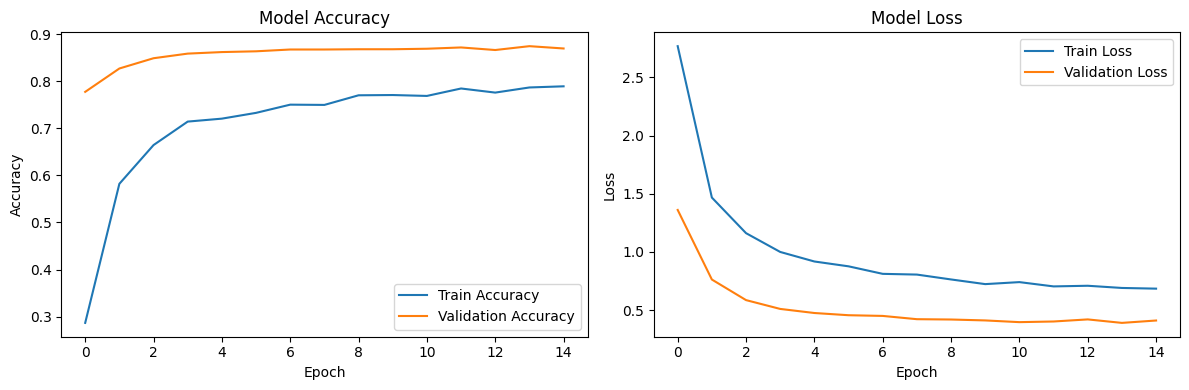

In [41]:
#  Train the new head
print("\n--- Warming up the new classifier head ---")

WARMUP_LR = 0.001
WARMUP_EPOCHS = 15 # Train the head for 15 epochs

criterion_2b = nn.CrossEntropyLoss()
# Optimize ONLY the parameters of the new 'fc' head
optimizer_2b_warmup = optim.Adam(resnet_2b_improved.fc.parameters(), lr=WARMUP_LR)
scheduler_2b_warmup = optim.lr_scheduler.ReduceLROnPlateau(optimizer_2b_warmup, 'min', patience=2, factor=0.1)

# Train the head
resnet_2b_improved, history_2b_warmup = train_model(
    resnet_2b_improved,
    criterion_2b,
    optimizer_2b_warmup,
    scheduler_2b_warmup,
    num_epochs=WARMUP_EPOCHS
)

print("--- Complete ---")
plot_history(history_2b_warmup)


--- Unfreezing all layers and fine-tuning ---
Unfreezing all model layers...
Epoch 1/20
----------
Train Loss: 0.6599 Acc: 0.7953
Val Loss: 0.3853 Acc: 0.8784
Epoch 2/20
----------
Train Loss: 0.6294 Acc: 0.8068
Val Loss: 0.3783 Acc: 0.8899
Epoch 3/20
----------
Train Loss: 0.5868 Acc: 0.8204
Val Loss: 0.3632 Acc: 0.8871
Epoch 4/20
----------
Train Loss: 0.5684 Acc: 0.8212
Val Loss: 0.3610 Acc: 0.8850
Epoch 5/20
----------
Train Loss: 0.5530 Acc: 0.8247
Val Loss: 0.3574 Acc: 0.8904
Epoch 6/20
----------
Train Loss: 0.5577 Acc: 0.8351
Val Loss: 0.3527 Acc: 0.8915
Epoch 7/20
----------
Train Loss: 0.5151 Acc: 0.8419
Val Loss: 0.3466 Acc: 0.8926
Epoch 8/20
----------
Train Loss: 0.5369 Acc: 0.8237
Val Loss: 0.3451 Acc: 0.8909
Epoch 9/20
----------
Train Loss: 0.5162 Acc: 0.8351
Val Loss: 0.3481 Acc: 0.8871
Epoch 10/20
----------
Train Loss: 0.5239 Acc: 0.8414
Val Loss: 0.3412 Acc: 0.8920
Epoch 11/20
----------
Train Loss: 0.4955 Acc: 0.8468
Val Loss: 0.3430 Acc: 0.8920
Epoch 12/20
------

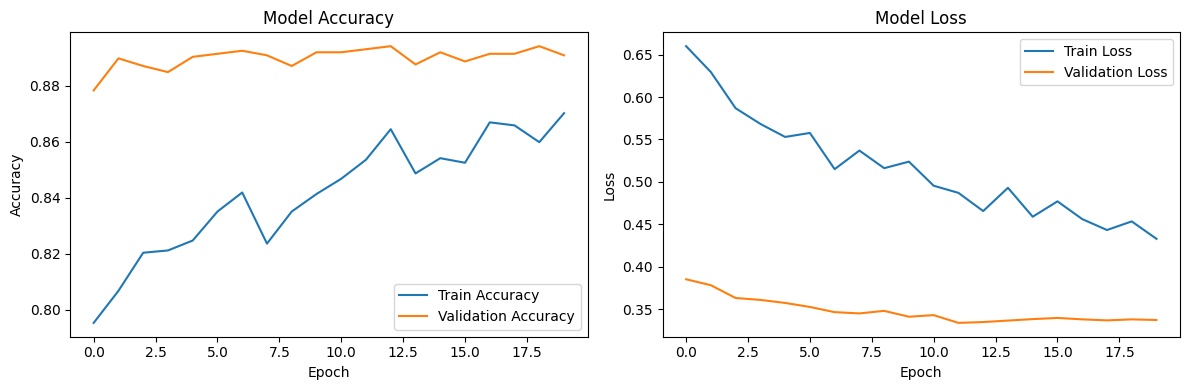

In [42]:
# Full Fine-Tuning
print("\n--- Unfreezing all layers and fine-tuning ---")

# Unfreeze all layers
print("Unfreezing all model layers...")
for param in resnet_2b_improved.parameters():
    param.requires_grad = True

# Use a VERY small learning rate
TUNE_LR = 0.00001
TUNE_EPOCHS = 20

# Optimizer now trains all parameters, but with the tiny LR
optimizer_2b_tune = optim.Adam(
    resnet_2b_improved.parameters(), # All parameters
    lr=TUNE_LR
)
scheduler_2b_tune = optim.lr_scheduler.ReduceLROnPlateau(optimizer_2b_tune, 'min', patience=3, factor=0.1)

# Continue Training
resnet_2b_improved, history_2b_tune = train_model(
    resnet_2b_improved,
    criterion_2b,
    optimizer_2b_tune,
    scheduler_2b_tune,
    num_epochs=TUNE_EPOCHS
)

print("--- Complete ---")
plot_history(history_2b_tune)

**Final Evaluation Part 2b**

Plotting full training history (Warmup + Fine-Tune)...


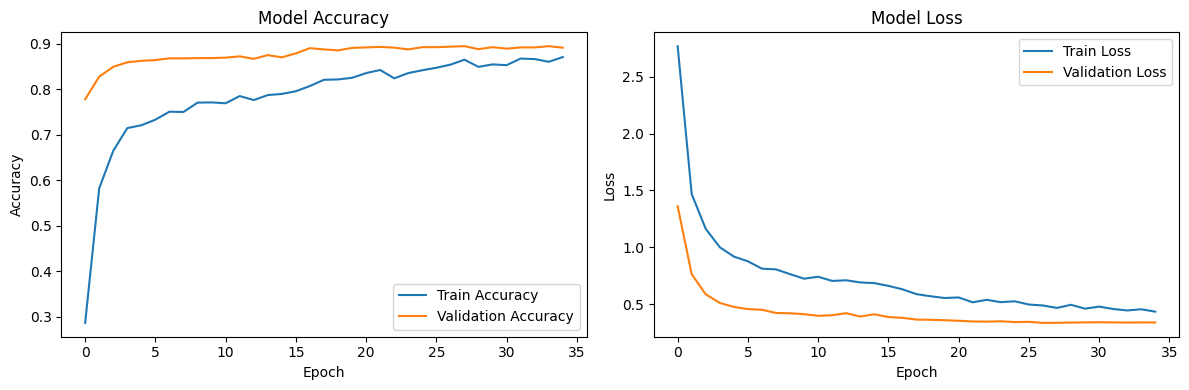

Evaluating 'ResNet-18 Part 2B (Improved)' on test set...
Test Accuracy (Part 2B Improved): 89.71%

--- Part 2: Fine-Tuning Results ---
Part 1 Best Model (for reference): 56.18%
| Model Variant               | Key Hyperparameters                                    | Test Accuracy |
|-----------------------------|--------------------------------------------------------|---------------|
| Part 2A (Feature Extract)   | LR=0.001, Head Only, 80 Epochs                        |88.84%         |
| Part 2B (Original)          | LR=0.0001, All Layers, 30 Epochs                       | 89.82%        |
| Part 2B (Improved)          | Dropout, 2-Phase Tune (LR=1e-05)                       | 89.71%        |

--- Visualizing the Improved Model ---


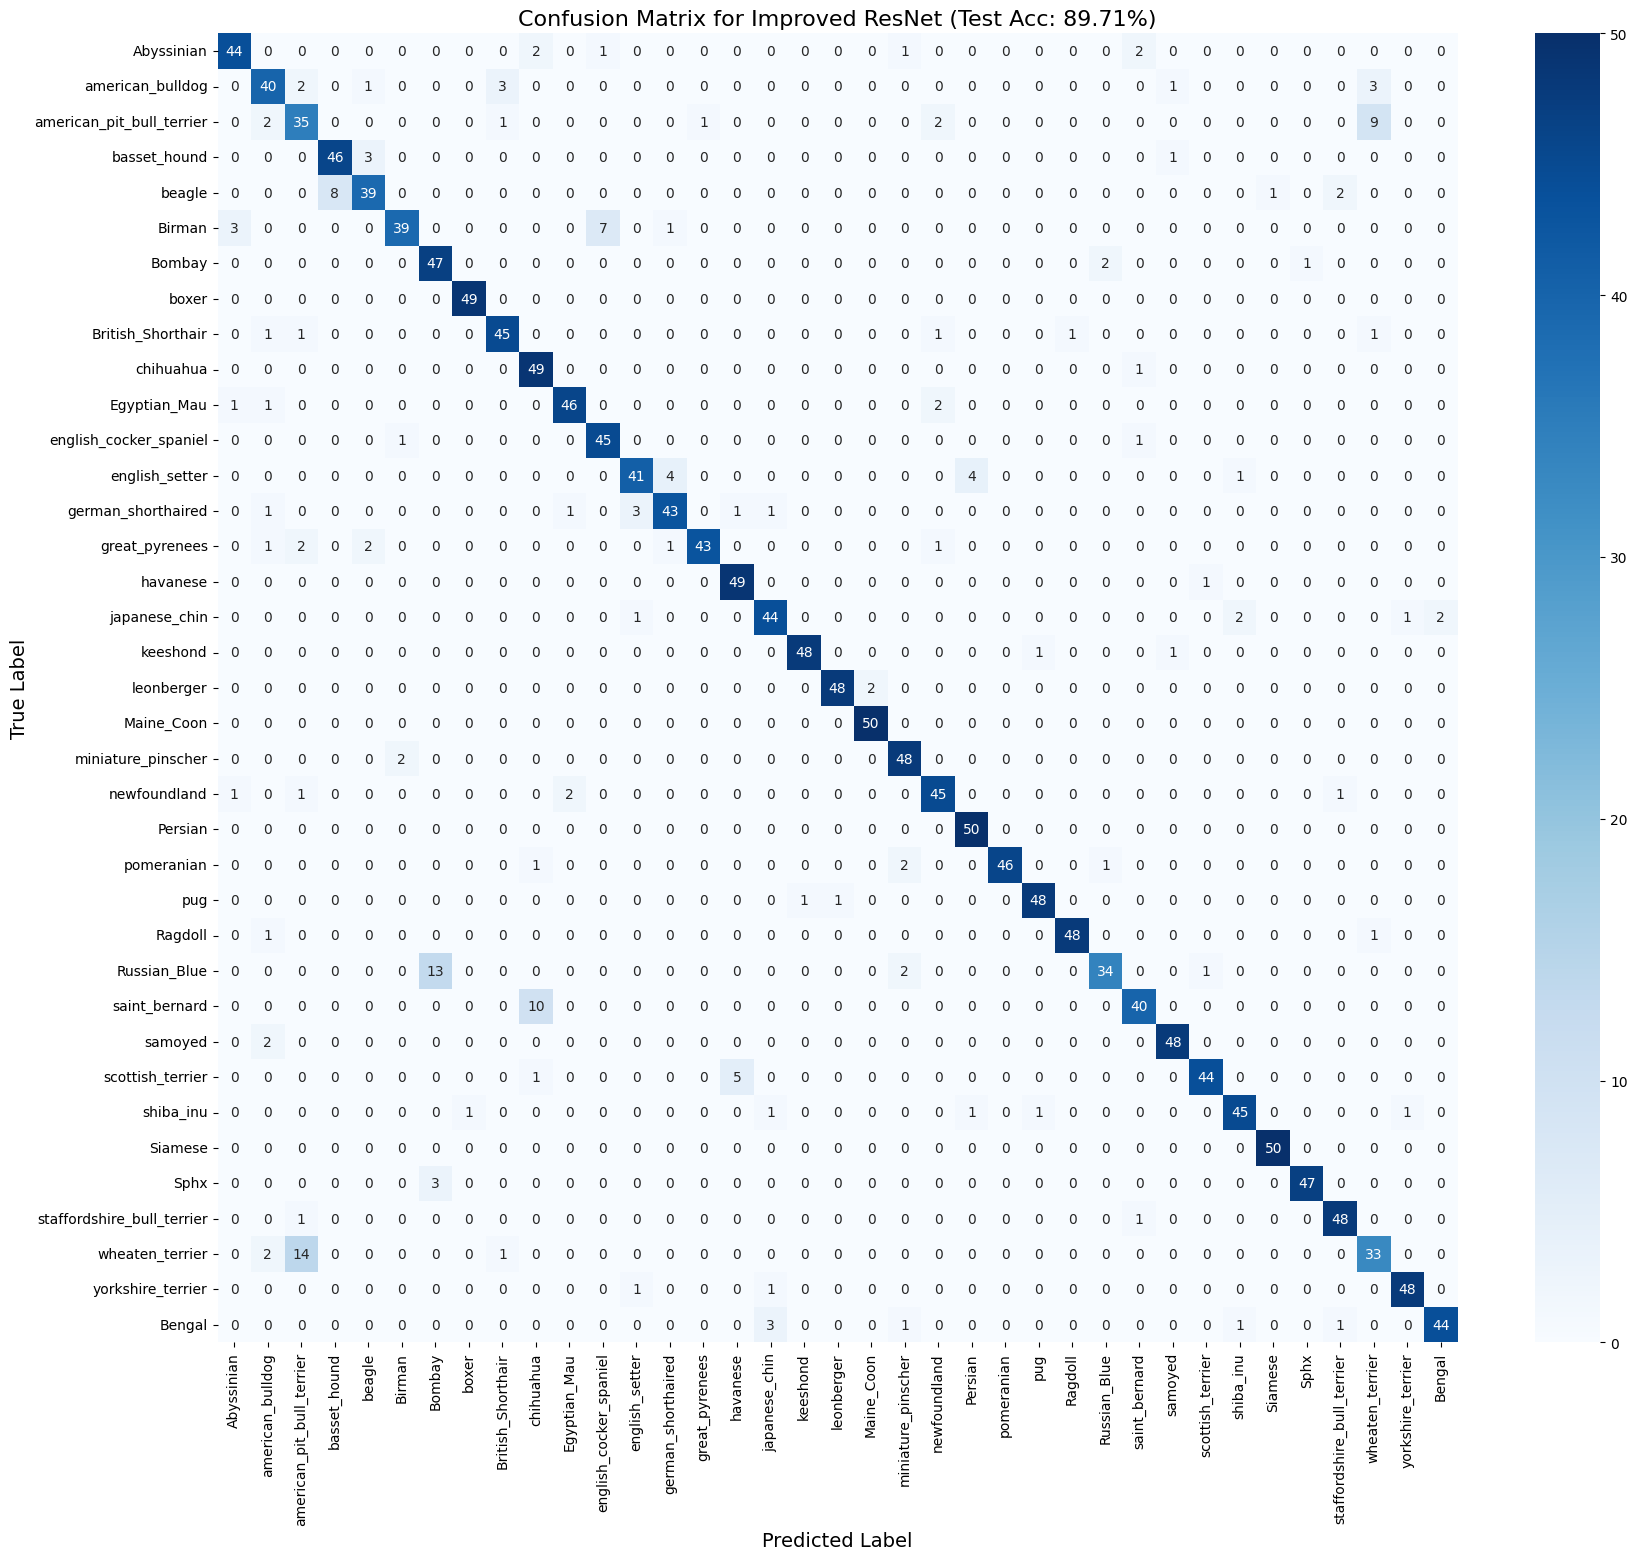

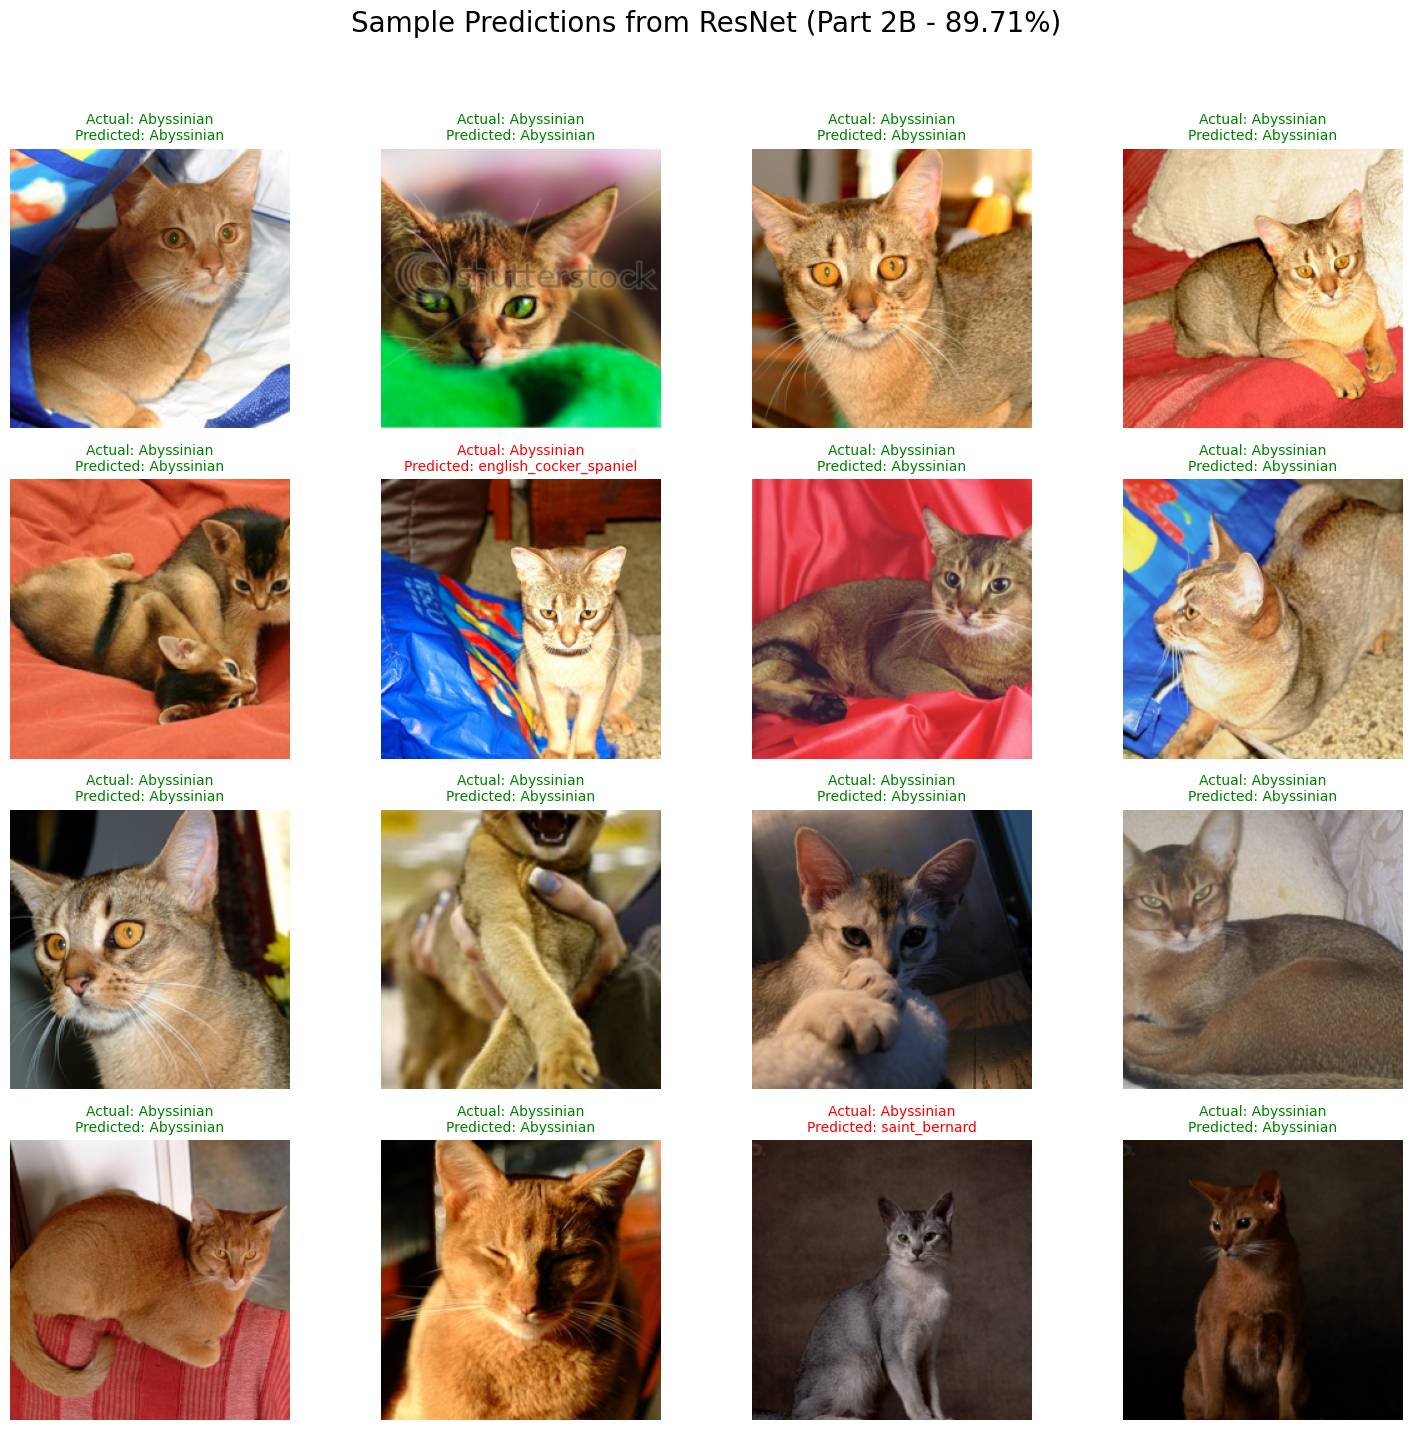

In [52]:
# Final Evaluation of Part 2B

# Plot the *entire* training history (Warmup + Tune)
full_history_2b = {
    'train_acc': history_2b_warmup['train_acc'] + history_2b_tune['train_acc'],
    'train_loss': history_2b_warmup['train_loss'] + history_2b_tune['train_loss'],
    'val_acc': history_2b_warmup['val_acc'] + history_2b_tune['val_acc'],
    'val_loss': history_2b_warmup['val_loss'] + history_2b_tune['val_loss']
}
print("Plotting full training history (Warmup + Fine-Tune)...")
plot_history(full_history_2b)


#  Evaluate on test set
print("Evaluating 'ResNet-18 Part 2B (Improved)' on test set...")
_, test_acc_2b_improved = validate(resnet_2b_improved, test_loader, criterion_2b, device)
print(f'Test Accuracy (Part 2B Improved): {test_acc_2b_improved*100:.2f}%')


#  Final Summary Table
print("\n--- Part 2: Fine-Tuning Results ---")
print(f"Part 1 Best Model (for reference): {test_acc_no_bn*100:.2f}%")
print("| Model Variant               | Key Hyperparameters                                    | Test Accuracy |")
print("|-----------------------------|--------------------------------------------------------|---------------|")
print(f"| Part 2A (Feature Extract)   | LR={LEARNING_RATE}, Head Only, 80 Epochs                        |{test_acc_2a*100:.2f}%         |")
print(f"| Part 2B (Original)          | LR=0.0001, All Layers, 30 Epochs                       | {test_acc_2b*100:.2f}%        |")
print(f"| Part 2B (Improved)          | Dropout, 2-Phase Tune (LR={TUNE_LR})                       | {test_acc_2b_improved*100:.2f}%        |")



print("\n--- Visualizing the Improved Model ---")
all_labels, all_preds = get_all_preds(resnet_2b_improved, test_loader)
cm_2b_imp = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(20, 17))
cm_df_2b_imp = pd.DataFrame(cm_2b_imp, index=class_names, columns=class_names)
sns.heatmap(cm_df_2b_imp, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix for Improved ResNet (Test Acc: {test_acc_2b_improved*100:.2f}%)', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.show()
print("\n")

visualize_predictions(
    resnet_2b_improved,
    test_loader,
    title=f"Sample Predictions from ResNet (Part 2B - {test_acc_2b_improved*100:.2f}%)"
)